In [2]:
# imports
from importlib import reload

import os # a module to interact with the operating system
os.environ["ENDPOINT_URL"]="http://rook-ceph-rgw-nautiluss3.rook"
import numpy as np

import pandas as pd
import xarray
import h5py
import healpy as hp
import time

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.plotting import plotting as ulmo_plotting
from ulmo.analysis import spatial_plots as sp

# Load Table

In [3]:
os.getenv('ENDPOINT_URL') 
tbl_file = 's3://modis-l2/Tables/MODIS_L2_std.parquet'
mod_table = ulmo_io.load_main_table(tbl_file)

Read main table: s3://modis-l2/Tables/MODIS_L2_std.parquet


In [4]:
tbl_file1 = 's3://llc/Tables/LLC_modis_noise.parquet'
llc_table = ulmo_io.load_main_table(tbl_file1)

Read main table: s3://llc/Tables/LLC_modis_noise.parquet


## Add year column

In [5]:
mod_year = mod_table.datetime.dt.year

In [6]:
mod_table['year'] = mod_year

In [7]:
mod_table.head()

,lat,lon,col,datetime,LL,row,clear_fraction,mean_temperature,Tmin,Tmax,T90,T10,filename,UID,pp_file,pp_root,field_size,pp_type,pp_idx,year
0,13.980967,62.675774,517,2003-03-10 21:25:00,520.178711,304,0.000000,26.199476,25.250000,26.885000,26.474998,25.814999,AQUA_MODIS.20030310T212506.L2.SST.nc,1047103981024267577,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,0,2003
1,13.043748,-102.751816,706,2003-12-12 08:30:00,432.766724,1696,0.049805,28.924648,27.789999,29.654999,29.154999,28.695000,AQUA_MODIS.20031212T083006.L2.SST.nc,107110304377724818,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,1,2003
2,-18.086618,40.844833,581,2003-09-24 22:35:00,764.413086,656,0.006104,25.551611,24.775000,26.154999,25.750000,25.344999,AQUA_MODIS.20030924T223506.L2.SST.nc,106471913422084483,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,2,2003
3,39.071575,18.569141,1028,2003-05-01 01:05:00,371.310120,898,0.049988,16.414951,15.160000,17.205000,16.725000,16.080000,AQUA_MODIS.20030501T010506.L2.SST.nc,1051129071619856914,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,3,2003
4,17.901926,90.155480,997,2003-12-05 19:55:00,-214.759277,1520,0.035461,26.744499,24.975000,28.724998,27.824999,25.830000,AQUA_MODIS.20031205T195506.L2.SST.nc,1070107901927015548,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,4,2003


## Constrain to only 99% clear

In [8]:
table2 = mod_table[ mod_table.clear_fraction < 0.01]
table2.head()

,lat,lon,col,datetime,LL,row,clear_fraction,mean_temperature,Tmin,Tmax,T90,T10,filename,UID,pp_file,pp_root,field_size,pp_type,pp_idx,year
0,13.980967,62.675774,517,2003-03-10 21:25:00,520.178711,304,0.000000,26.199476,25.250000,26.885000,26.474998,25.814999,AQUA_MODIS.20030310T212506.L2.SST.nc,1047103981024267577,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,0,2003
2,-18.086618,40.844833,581,2003-09-24 22:35:00,764.413086,656,0.006104,25.551611,24.775000,26.154999,25.750000,25.344999,AQUA_MODIS.20030924T223506.L2.SST.nc,106471913422084483,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,2,2003
11,18.458124,62.417706,709,2003-10-18 21:35:00,554.128296,816,0.000183,27.821482,27.184999,28.555000,28.070000,27.590000,AQUA_MODIS.20031018T213506.L2.SST.nc,1066108458124241771,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,11,2003
19,-33.024510,131.990810,261,2003-04-17 16:05:00,347.220886,48,0.000549,18.951015,17.240000,19.879999,19.430000,18.379999,AQUA_MODIS.20030417T160506.L2.SST.nc,105056975531199081,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,19,2003
22,12.451444,-18.484682,645,2003-12-11 02:50:00,448.238098,1808,0.002563,26.857893,26.029999,27.699999,27.269999,26.480000,AQUA_MODIS.20031211T025006.L2.SST.nc,1071102451416151532,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,22,2003


## Remove NaN cutouts

In [9]:
table = table2[ ~table2.LL.isnull()]

In [10]:
table.shape

(3925915, 20)

# Functions

In [11]:
def show_spatial_two_avg(tbl1:pd.DataFrame, tbl2:pd.DataFrame, 
                 nside=64, use_log=True, 
                 use_mask=True, tricontour=False,
                 lbl=None, figsize=(12,8), 
                 color='coolwarm', show=True):
    """Generate a global map of the location of the input
    cutouts

    Args:
        main_tbl (pandas.DataFrame): table of cutouts
        nside (int, optional): [description]. Defaults to 64.
        use_log (bool, optional): [description]. Defaults to True.
        use_mask (bool, optional): [description]. Defaults to True.
        tricontour (bool, optional): [description]. Defaults to False.
        lbl ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (12,8).
        color (str, optional): [description]. Defaults to 'Reds'.
        show (bool, optional): If True, show on the screen.  Defaults to True

    Returns:
        matplotlib.Axis: axis holding the plot
    """
    # Healpix me
    hp_events1, hp_lons1, hp_lats1, hp_values1 = sp.evals_to_healpix(
        tbl1, nside, log=use_log, mask=use_mask)
    
    hp_events2, hp_lons2, hp_lats2, hp_values2 = sp.evals_to_healpix(
        tbl2, nside, log=use_log, mask=use_mask)
    
    # Figure
    
    fig = plt.figure(figsize=figsize)
    plt.clf()

    tformM = ccrs.Mollweide()
    tformP = ccrs.PlateCarree()

    ax = plt.axes(projection=tformM)

    if tricontour:
        cm = plt.get_cmap(color)
        img = ax.tricontourf(hp_lons1, hp_lats1, hp_values1 - hp_values2, transform=tformM,
                         levels=20, cmap=cm)#, zorder=10)
    else:
        cm = plt.get_cmap(color)
        # Cut
        good = np.invert(hp_values2.mask)
        img = plt.scatter(x=hp_lons2[good],
            y=hp_lats2[good],
            c=hp_values1[good]- hp_values2[good], vmin = -300, vmax = 300, 
            cmap=cm,
            s=1,
            transform=tformP)

    # Colorbar
    cb = plt.colorbar(img, orientation='horizontal', pad=0.)
    if lbl is not None:
        #clbl=r'$\log_{10} \, N_{\rm '+'{}'.format(lbl)+'}$'
        clbl = 'diff_mean_LL'
        cb.set_label(clbl, fontsize=20.)
    cb.ax.tick_params(labelsize=17)

    # Coast lines
    if not tricontour:
        ax.coastlines(zorder=10)
        ax.set_global()
    
        gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
            color='black', alpha=0.5, linestyle=':', draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_left = True
        gl.ylabels_right=False
        gl.xlines = True
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'color': 'black'}# 'weight': 'bold'}
        gl.ylabel_style = {'color': 'black'}# 'weight': 'bold'}
        #gl.xlocator = mticker.FixedLocator([-180., -160, -140, -120, -60, -20.])
        #gl.xlocator = mticker.FixedLocator([-240., -180., -120, -65, -60, -55, 0, 60, 120.])
        #gl.ylocator = mticker.FixedLocator([0., 15., 30., 45, 60.])


    # Layout and save
    if show:
        plt.show()

    return ax

In [12]:
def show_spatial_two_med(tbl1:pd.DataFrame, tbl2:pd.DataFrame, 
                 nside=64, 
                 use_mask=True, tricontour=False,
                 lbl=None, figsize=(12,8), 
                 color='coolwarm', show=True):
    """Generate a global map of the location of the input
    cutouts

    Args:
        main_tbl (pandas.DataFrame): table of cutouts
        nside (int, optional): [description]. Defaults to 64.
        use_log (bool, optional): [description]. Defaults to True.
        use_mask (bool, optional): [description]. Defaults to True.
        tricontour (bool, optional): [description]. Defaults to False.
        lbl ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (12,8).
        color (str, optional): [description]. Defaults to 'Reds'.
        show (bool, optional): If True, show on the screen.  Defaults to True

    Returns:
        matplotlib.Axis: axis holding the plot
    """
    # Healpix me
    hp_events1, hp_lons1, hp_lats1, hp_values1 = sp.evals_to_healpix_meds(
        tbl1, nside, mask=use_mask)
    
    hp_events2, hp_lons2, hp_lats2, hp_values2 = sp.evals_to_healpix_meds(
        tbl2, nside, mask=use_mask)
    
    # Figure
    
    fig = plt.figure(figsize=figsize)
    plt.clf()

    tformM = ccrs.Mollweide()
    tformP = ccrs.PlateCarree()

    ax = plt.axes(projection=tformM)

    if tricontour:
        cm = plt.get_cmap(color)
        img = ax.tricontourf(hp_lons1, hp_lats1, hp_values1 - hp_values2, transform=tformM,
                         levels=20, cmap=cm)#, zorder=10)
    else:
        cm = plt.get_cmap(color)
        # Cut
        good = np.invert(hp_values2.mask)
        img = plt.scatter(x=hp_lons2[good],
            y=hp_lats2[good],
            c=hp_values1[good]- hp_values2[good], vmin = -300, vmax = 300, 
            cmap=cm,
            s=1,
            transform=tformP)

    # Colorbar
    cb = plt.colorbar(img, orientation='horizontal', pad=0.)
    if lbl is not None:
        #clbl=r'$\log_{10} \, N_{\rm '+'{}'.format(lbl)+'}$'
        clbl = 'diff median LL'
        cb.set_label(clbl, fontsize=20.)
    cb.ax.tick_params(labelsize=17)

    # Coast lines
    if not tricontour:
        ax.coastlines(zorder=10)
        ax.set_global()
    
        gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
            color='black', alpha=0.5, linestyle=':', draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_left = True
        gl.ylabels_right=False
        gl.xlines = True
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'color': 'black'}# 'weight': 'bold'}
        gl.ylabel_style = {'color': 'black'}# 'weight': 'bold'}
        #gl.xlocator = mticker.FixedLocator([-180., -160, -140, -120, -60, -20.])
        #gl.xlocator = mticker.FixedLocator([-240., -180., -120, -65, -60, -55, 0, 60, 120.])
        #gl.ylocator = mticker.FixedLocator([0., 15., 30., 45, 60.])


    # Layout and save
    if show:
        plt.show()

    return ax

In [13]:
def scatter_diff_avg(tbl1:pd.DataFrame, tbl2:pd.DataFrame, 
                 nside=32, use_log=False, 
                 use_mask=True, tricontour=False,
                 lbl=None, figsize=(12,8), 
                 color='plasma', show=True):
    """Generate a scatter plot with the difference of mean LL between two
    dataframes (pixel-wise) as a function of the number of cutouts

    Args:
        main_tbl (pandas.DataFrame): table of cutouts
        nside (int, optional): [description]. Defaults to 64.
        use_log (bool, optional): [description]. Defaults to True.
        use_mask (bool, optional): [description]. Defaults to True.
        tricontour (bool, optional): [description]. Defaults to False.
        lbl ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (12,8).
        color (str, optional): [description]. Defaults to 'Reds'.
        show (bool, optional): If True, show on the screen.  Defaults to True

    Returns:
        matplotlib.Axis: axis holding the plot
    """
    # Healpix me
    hp_events1, hp_lons1, hp_lats1, hp_values1 = sp.evals_to_healpix(
        tbl1, nside, log=use_log, mask=use_mask)
    
    hp_events2, hp_lons2, hp_lats2, hp_values2 = sp.evals_to_healpix(
        tbl2, nside, log=use_log, mask=use_mask)
    
    # Figure
    
    fig = plt.figure(figsize=figsize)
    plt.clf()
    cm = plt.get_cmap(color)
        
    # Cut
    good = np.invert(hp_values2.mask)
    ax = plt.scatter(x= hp_events2[good] , y = hp_values1[good]- hp_values2[good], s=1)

    # Colorbar
    #cb = plt.colorbar(ax, orientation='vertical', pad=0.1)
    #if lbl is not None:
        #clbl=r'$\log_{10} \, N_{\rm '+'{}'.format(lbl)+'}$'
    #    clbl = 'diff_mean_LL'
    #    cb.set_label(clbl, fontsize=20.)
    #cb.ax.tick_params(labelsize=17)

    # Axis Labels
    plt.xlabel('num of cutouts : table 2')
    plt.ylabel('diff_mean_LL')
    plt.ylim(-1000, 1000)


    # Layout and save
    if show:
        plt.show()

    return ax

In [14]:
def scatter_diff_med(tbl1:pd.DataFrame, tbl2:pd.DataFrame, 
                 nside=32,  
                 use_mask=True, tricontour=False,
                 lbl=None, figsize=(12,8), 
                 color='plasma', show=True):
    """Generate a scatter plot with the difference of mean LL between two
    dataframes (pixel-wise) as a function of the number of cutouts

    Args:
        main_tbl (pandas.DataFrame): table of cutouts
        nside (int, optional): [description]. Defaults to 64.
        use_log (bool, optional): [description]. Defaults to True.
        use_mask (bool, optional): [description]. Defaults to True.
        tricontour (bool, optional): [description]. Defaults to False.
        lbl ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (12,8).
        color (str, optional): [description]. Defaults to 'Reds'.
        show (bool, optional): If True, show on the screen.  Defaults to True

    Returns:
        matplotlib.Axis: axis holding the plot
    """
    # Healpix me
    hp_events1, hp_lons1, hp_lats1, hp_values1 = sp.evals_to_healpix_meds(
        tbl1, nside, mask=use_mask)
    
    hp_events2, hp_lons2, hp_lats2, hp_values2 = sp.evals_to_healpix_meds(
        tbl2, nside, mask=use_mask)
    
    # Figure
    
    fig = plt.figure(figsize=figsize)
    plt.clf()
    cm = plt.get_cmap(color)
        
    # Cut
    good = np.invert(hp_values2.mask)
    ax = plt.scatter(x= hp_events2[good] , y = hp_values1[good]- hp_values2[good], s=1)

    # Colorbar
    #cb = plt.colorbar(ax, orientation='vertical', pad=0.1)
    #if lbl is not None:
        #clbl=r'$\log_{10} \, N_{\rm '+'{}'.format(lbl)+'}$'
    #    clbl = 'diff_mean_LL'
    #    cb.set_label(clbl, fontsize=20.)
    #cb.ax.tick_params(labelsize=17)

    # Axis Labels
    plt.xlabel('num of cutouts : table 2')
    plt.ylabel('diff_median_LL')
    plt.ylim(-1000, 1000)


    # Layout and save
    if show:
        plt.show()

    return ax

# Check for a temporal trend

## 2003 to 2008

In [15]:
mod_start = table[ (table.year > 2003) & (table.year < 2009) ]

## 2013 to 2018

In [16]:
mod_end = table[ (table.year > 2015) & (table.year < 2020) ]

### Show avg LL 

/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:348: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


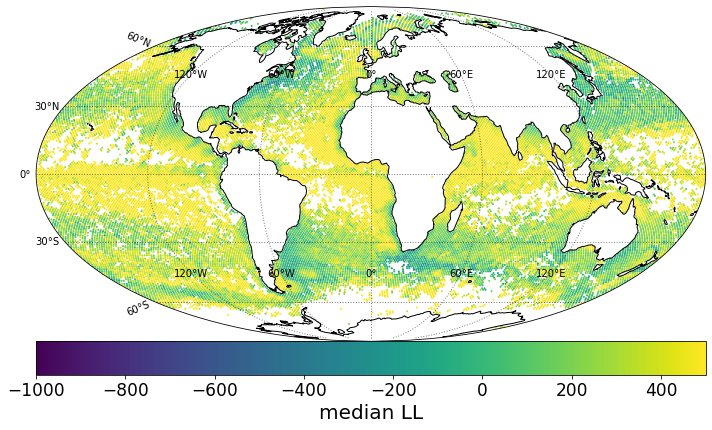

In [17]:
_ = sp.show_med_LL(mod_start, lbl = True)

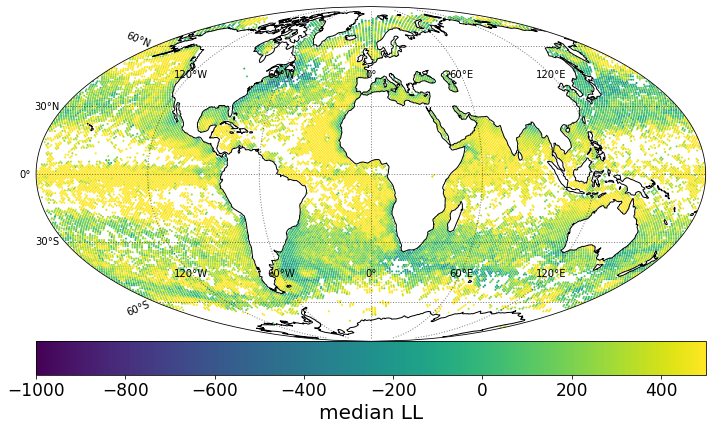

In [18]:
_ = sp.show_med_LL(mod_end, lbl = True)

/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:348: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


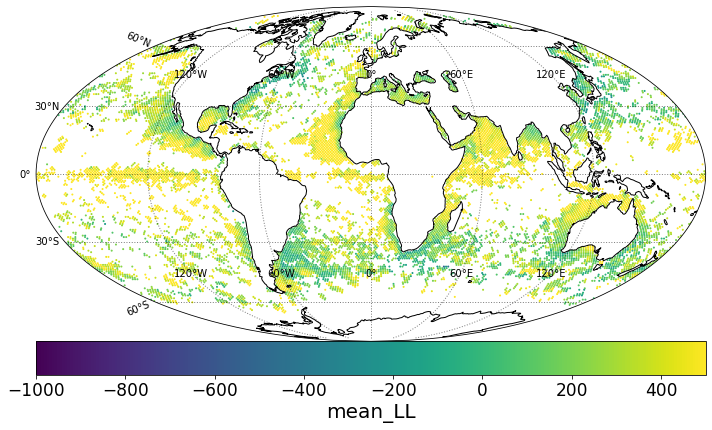

In [19]:
_ = sp.show_avg_LL(table[table.year == 2012], lbl = True)

### Show diff in avg LL

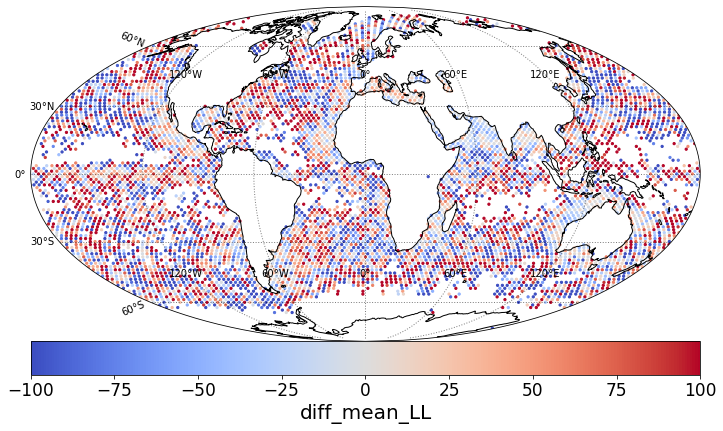

<GeoAxesSubplot:>

In [135]:
show_spatial_two(mod_end, mod_start, lbl=True)

## Scatter diff

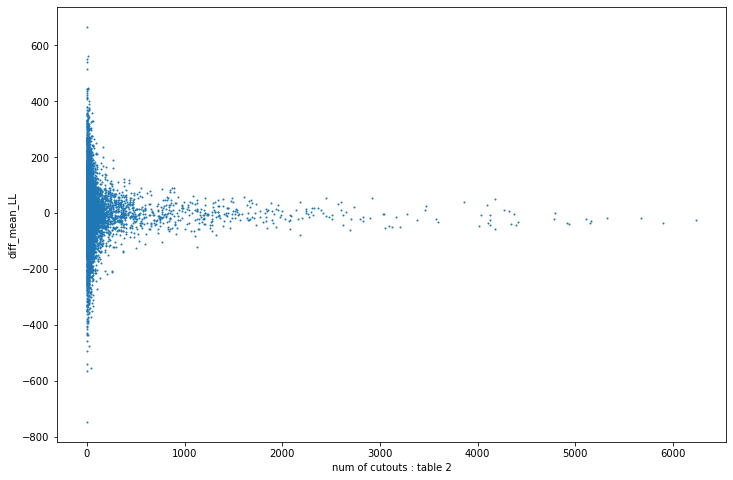

In [114]:
scatter_diff(mod_end, mod_start, lbl = True)

In [112]:
NSIDE = 32
print("Approximate resolution at NSIDE {} is {:.2} deg".format(NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60))

Approximate resolution at NSIDE 32 is 1.8 deg


In [87]:
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

12288


In [90]:
mod_end.shape[0]/12288

61.18603515625

# MODIS: all years vs 2012

In [130]:
ally = table[table.year != 2012]

In [131]:
year2012 = table[ table.year==2012]

### Diff in mean LL

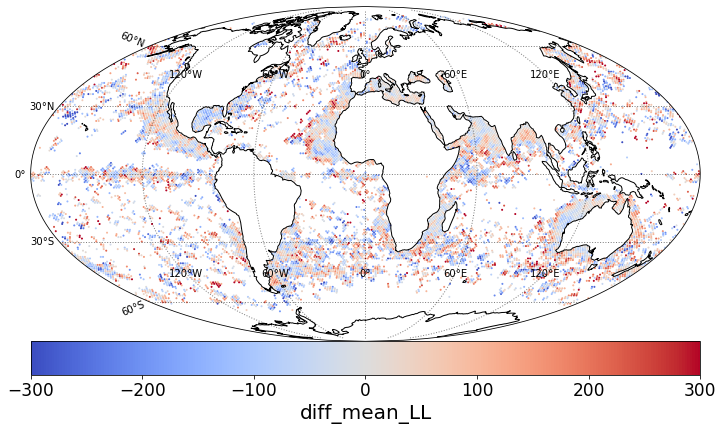

<GeoAxesSubplot:>

In [148]:
show_spatial_two(ally, year2012, lbl=True)

### As a function of num of cutouts

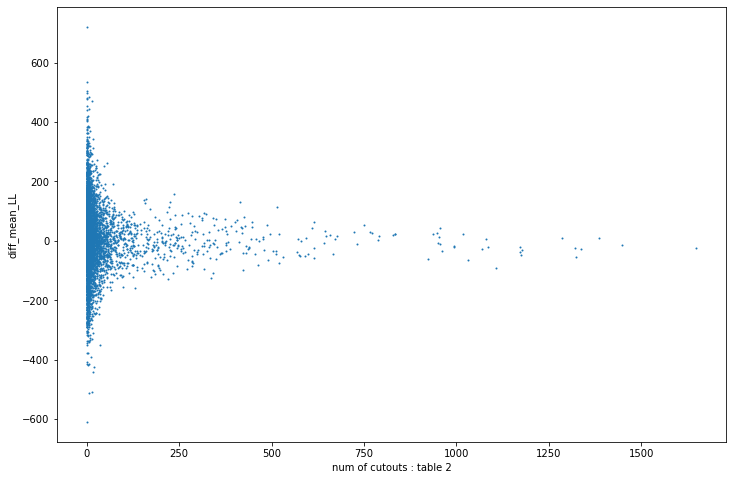

In [141]:
scatter_diff(ally, year2012, lbl = True)

### LL dist

(-2000.0, 1000.0)

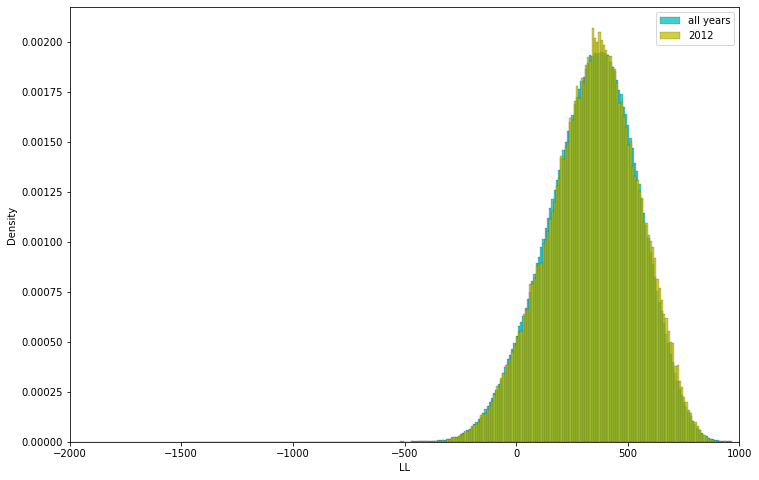

In [144]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()
_ = sns.histplot(ally, x='LL', ax=ax, binwidth = 10, stat = 'density', label = 'all years', color = 'c')
_ = sns.histplot(year2012, x='LL', ax=ax, binwidth = 10, stat = 'density', label = '2012', color = 'y')
ax.legend()
ax.set_xlim(-2000., 1000.)

# Check LL Distributions

(-2000.0, 1000.0)

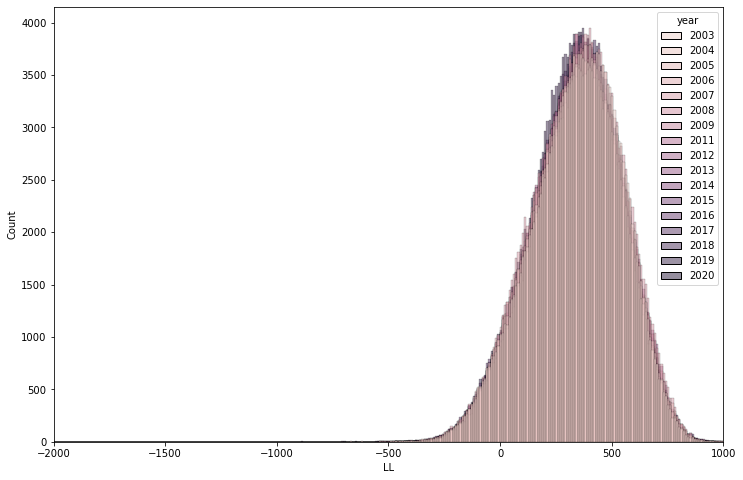

In [18]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()
_ = sns.histplot(table, x='LL', hue='year', ax=ax, binwidth = 10)
ax.set_xlim(-2000., 1000.)

# MODIS: all years vs LLC

### Diff in mean LL

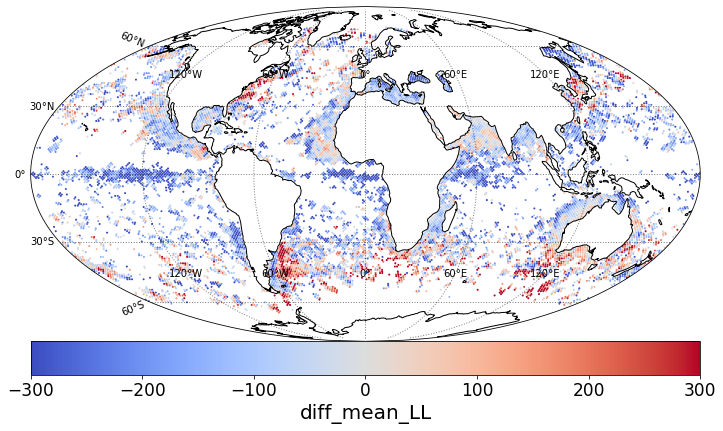

<GeoAxesSubplot:>

In [152]:
show_spatial_two(year2012, llc_table, lbl=True)

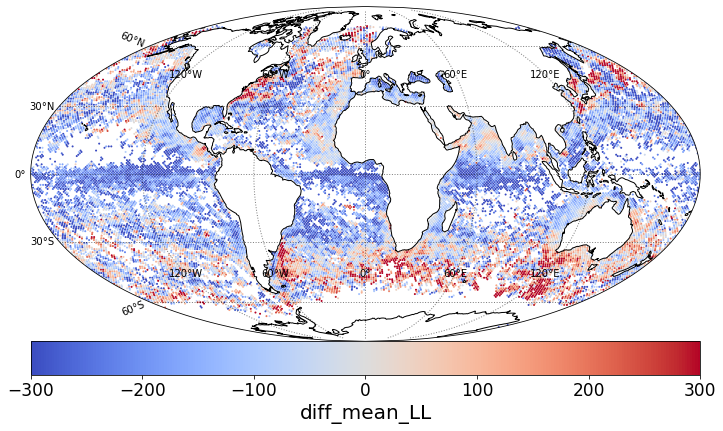

<GeoAxesSubplot:>

In [153]:
show_spatial_two(table, llc_table, lbl=True)

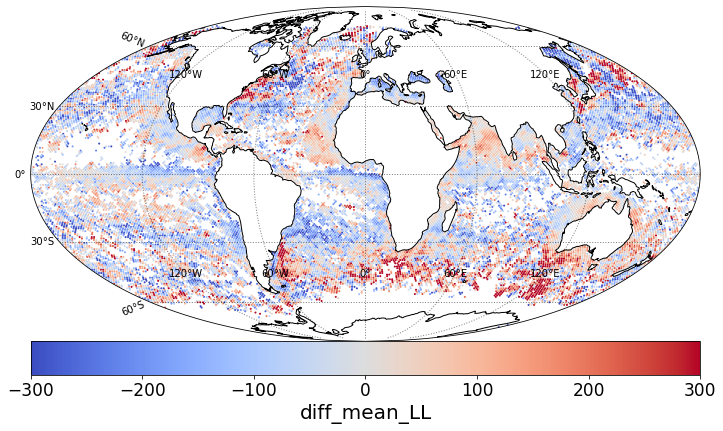

<GeoAxesSubplot:>

In [155]:
show_spatial_two(table, llc_table1, lbl=True)

# Create h5 file to contain the wanted cutouts

In [9]:
with h5py.File( '/home/jovyan/modis_all_99_clear_preproc.h5', 'w' ) as g:
        
    g.create_dataset( 'valid', (table.shape[0], 1, 64, 64))
    g.create_dataset( 'valid_metadata', (table.shape[0], 11))

In [10]:
table.shape[0]

3925915

In [11]:
file_lst = pd.unique(table.pp_file)
k = 0

In [12]:
file_lst

array(['s3://modis-l2/PreProc/MODIS_R2019_2003_95clear_128x128_preproc_std.h5',
       's3://modis-l2/PreProc/MODIS_R2019_2004_95clear_128x128_preproc_std.h5',
       's3://modis-l2/PreProc/MODIS_R2019_2005_95clear_128x128_preproc_std.h5',
       's3://modis-l2/PreProc/MODIS_R2019_2006_95clear_128x128_preproc_std.h5',
       's3://modis-l2/PreProc/MODIS_R2019_2007_95clear_128x128_preproc_std.h5',
       's3://modis-l2/PreProc/MODIS_R2019_2008_95clear_128x128_preproc_std.h5',
       's3://modis-l2/PreProc/MODIS_R2019_2009_95clear_128x128_preproc_std.h5',
       's3://modis-l2/PreProc/MODIS_R2019_2010_95clear_128x128_preproc_std.h5',
       's3://modis-l2/PreProc/MODIS_R2019_2011_95clear_128x128_preproc_std.h5',
       's3://modis-l2/PreProc/MODIS_R2019_2012_95clear_128x128_preproc_std.h5',
       's3://modis-l2/PreProc/MODIS_R2019_2013_95clear_128x128_preproc_std.h5',
       's3://modis-l2/PreProc/MODIS_R2019_2014_95clear_128x128_preproc_std.h5',
       's3://modis-l2/PreProc/MODIS_R201

In [13]:
file = file_lst[0]
filename = '/home/jovyan/MODIS_R2019_2003_95clear_128x128_preproc_std.h5'

In [15]:
j = np.max( np.where( file ==table.pp_file ) )
j

242048

In [16]:
with h5py.File( filename, 'r' ) as f: 
    print( f['valid'].shape)

(760417, 1, 64, 64)


In [ ]:
start = time.time()

# grab the pp indices
j = np.max( np.where( file ==table.pp_file ) )
idxs = table.iloc[ k: k + j + 1].sort_values('pp_idx').pp_idx.to_numpy()

# grab the imgs and data
g = h5py.File(filename, 'r')

imgs = g['valid'][idxs, 0, ...]
mdat = g['valid_metadata'][idxs, ...]

g.close()


end = time.time()
print(end-start)

In [ ]:
start = time.time()

# grab the pp indices
j = np.max( np.where( file ==table.pp_file ) )
idxs = table[ k: k + j].pp_idx.to_numpy()

# grab the imgs and data
g = h5py.File(filename, 'r')

imgs = g['valid'][idxs, 0, ...]
mdat = g['valid_metadata'][idxs, ...]

g.close()


end = time.time()
print(end-start)

In [32]:
imgs.shape

(242048, 64, 64)

In [25]:
j

242048

In [33]:
with h5py.File( '/home/jovyan/modis_all_99_clear_preproc.h5', 'r+' ) as g:
        
    g['valid'][k:k+j, 0, ...] = imgs